Approximation to continuous POMDP implemented using `github.com/JuliaPOMDP/QuickPOMDPs.jl` and solved using POMCP with reference to tutorial [here](https://htmlview.glitch.me/?https://github.com/JuliaAcademy/Decision-Making-Under-Uncertainty/blob/master/html/4-Approximate-Methods.jl.html).

In [1]:
using POMDPs, QuickPOMDPs, POMDPModelTools, POMDPPolicies, Parameters, Random, Plots, LinearAlgebra, Serialization
using POMDPTools, BasicPOMCP, D3Trees, GridInterpolations, POMCPOW, POMDPModels, Combinatorics, Dates, CSV, ParticleFilters

In [2]:
expID = Dates.format(Dates.now(), "yymd_HHMMS")

"23313_153754"

In [3]:
function log(s::String)
    s_time = Dates.format(Dates.now(), "HH:MM:SS\t")*s*"\n"
    open("./logs/"*expID*".txt", "a") do file
        write(file, s_time)
    end
    print(s_time)
end

log (generic function with 1 method)

In [4]:
log("Running experiment with ID "*expID)

15:37:55	Running experiment with ID 23313_153754


# Define Problem

In [5]:
@with_kw struct MyParameters
    N::Int = 3         # size of item set
    K::Int = 3         # size of arm set
    M::Int = 3        # size of beta set
    y::Real = 0.9     # discount factor
    umax::Real = 10    # max utility
    u_grain:: Int = 3  # granularity of utility approximation
    d_grain:: Int = 3  # granularity of arm distribution approximation
    beta:: Array{Float64} = [0, 0.01, 50.0]  # teacher beta values
    exp_iters::Int = 3   # number of rollouts to run
    exp_steps::Int = 100   # number of timesteps per rollout
#     s_index::Int = parse(Int64, ARGS[8])     # index of true state
end

params = MyParameters()
log(string(params))

15:37:55	MyParameters
  N: Int64 3
  K: Int64 3
  M: Int64 3
  y: Float64 0.9
  umax: Int64 10
  u_grain: Int64 3
  d_grain: Int64 3
  beta: Array{Float64}((3,)) [0.0, 0.01, 50.0]
  exp_iters: Int64 3
  exp_steps: Int64 100



# Create POMDP

In [6]:
struct State
    t::Int                    # timesteps remaining
    u::Array{Float64}         # list of N utility values for N items
    d::Array{Array{Float64}}  # list of K arm distributions, each assigning probabilities to N items
    b::Array{Float64}         # list of M beta values
end

In [7]:
# space of utility functions
@time begin
    umin = 0
    grid_coor = fill(range(umin,params.umax,length=params.u_grain), params.N)
    U = RectangleGrid(grid_coor...)
end

@assert length(U[1]) == params.N
log("generated "*string(length(U))*" utilities (each length "*string(length(U[1]))*" items)")

  0.119921 seconds (163.60 k allocations: 8.391 MiB, 99.51% compilation time)
15:37:55	generated 27 utilities (each length 3 items)


In [8]:
function generate_probability_distributions(N::Int, coor::Array{Float64}, S::Float64=1.0)
    if S == 0
        return [[0. for _ in 1:N]]
    end
    if N == 1
        return [[float(S)]]
    end
    out = []
    range = coor[1:findall(x->isapprox(x,S,atol=1e-15), coor)[1]]
    for k in range
        subsolution = generate_probability_distributions(N-1, coor, S-k)
        for lst in subsolution
            if typeof(lst[1]) != Float64
                log("ERROR: lst "*string(lst)*" has type "*string(typeof(lst[1]))*". Must be Float64.")
            end
            prepend!(lst, float(k))
        end
        out = vcat(out, subsolution)
    end
    return out
end

generate_probability_distributions (generic function with 2 methods)

In [9]:
# space of arm distributions
@time begin
    coor = collect(range(0.,1.,length=params.d_grain))    
    simplex_list = generate_probability_distributions(params.N, coor)
    D_tuples = vec(collect(Base.product(fill(simplex_list, params.K)...)))
    D = [collect(d) for d in D_tuples]
end

@assert length(D[1]) == params.K
@assert length(D[1][1]) == params.N
log(string("generated "*string(length(D))*" arm distribution sets (each shape "*string(length(D[1]))*" arms x "*string(length(D[1][1]))*" items)"))
    
    

  0.257468 seconds (1.59 M allocations: 81.502 MiB, 98.80% compilation time)
15:37:55	generated 216 arm distribution sets (each shape 3 arms x 3 items)


In [10]:
# beta values
B = [params.beta]

# each beta value set must be length M
@assert length(B[1]) == params.M
log(string("generated "*string(length(B))*" beta value sets (each length "*string(length(B[1]))*" teachers)"))

15:37:55	generated 1 beta value sets (each length 3 teachers)


In [33]:
# State space
@time begin    
    S = [[State(t,u,d,b) for u in U, d in D, b in B, t in params.exp_steps:-1:1]...,]
end

# absorbing state
final = State(0, zeros(params.N), [zeros(params.N) for _ in 1:params.K], zeros(params.M))
push!(S, final)

# initial states
S_init = S[1:length(U)*length(D)*length(B)]

log("generated "*string(length(S))*" states")

  0.182453 seconds (2.44 M allocations: 178.542 MiB, 26.35% compilation time)
10:09:17	generated 583201 states


In [12]:
function interesting(s::State)
    e = [dot(s.u, di) for di in s.d]
    order = e[1] > e[2] && e[2] >= e[3] 
    diff = s.d[1] != s.d[2] != s.d[3]
    stoch = all([s.d[i][j]!=1. for i in 1:3, j in 1:3])
    return order && stoch && diff
end

to_print = false
indices = []
for i in 1:length(S)
    if interesting(S[i])
        if to_print
            println("index ", i)
            println(S[i])
        end
        push!(indices, i)
    end
end

# length(indices)/length(S)
rand(indices, 10)

10-element Vector{Any}:
 561597
 438975
 511539
 371020
 284350
 176682
 441555
 503136
 208543
 334008

In [13]:
function print_state(s::State)
    println("\t t: ", s.t)
    println("\t u: ", s.u)
    println("\t d1: ", s.d[1], "\t (exp val ", dot(s.u, s.d[1]), ")")
    println("\t d1: ", s.d[2], "\t (exp val ", dot(s.u, s.d[2]), ")")
    println("\t d1: ", s.d[3], "\t (exp val ", dot(s.u, s.d[3]), ")")
end

state_IDs = [123]

for ID in state_IDs
    println("\nState ", ID, ":")
    print_state(S[ID])
end


State 724392:


LoadError: BoundsError: attempt to access 583201-element Vector{State} at index [724392]

In [14]:
# Action space - actions are arm choices (K) or beta selections (M)
struct Action
    name::String      # valid names are {B,C} + index
    isBeta::Bool      # true if 'B' action, false if 'C' action
    index::Integer    # index of beta (if 'B' action) or arm choice (if 'C' action)
end

A = Array{Action}(undef, params.K+params.M)
for i in 1:params.K+params.M
    if i <= params.K
        A[i] = Action("C"*string(i), false, i)
    else
        A[i] = Action("B"*string(i-params.K), true, i-params.K)
    end
end
log("generated "*string(length(A))*" actions")

15:37:58	generated 6 actions


In [15]:
# Transition function
function next(s::State)
    # after final timestep, transition to absorbing state
    if s.t <= 1
        return S[end]
    end
    return State(s.t-1, s.u, s.d, s.b)
end

function T(s::State, a::Action)
    s_prime = next(s)
    return SparseCat([s_prime], [1.0])    # categorical distribution
end
log("generated transition function")

15:37:58	generated transition function


In [16]:
# Reward function
function R(s::State, a::Action)
    # if absorbing state, return 0
    if s.t == 0
        return 0
    end
    
    # if beta selected, return 0
    if a.isBeta
        return 0
    # if arm pulled, return that arm's avg utility
    else
        utilities = s.u
        arm_dist = s.d[a.index]
        return dot(utilities, arm_dist)
    end
end
log("generated reward function")

15:37:58	generated reward function


In [17]:
# item space
I = 1:params.N

# preference space
struct Preference
    i0::Int    # first item to compare, in {1,2,...,N}
    i1::Int    # second item to compare, in {1,2,...,N}
    label::Int # feedback label, in {0,1}
end

P = [[Preference(i0,i1,label) for i0 in I, i1 in I, label in [0,1]]...,]

# observation space
struct Observation
    isItem::Bool    # true if item returned, false otherwise
    i::Int          # item, if item returned
    p::Preference   # preference, if preference returned
end

invalid_i = -1
invalid_p = Preference(-1,-1,-1)
I_obs = [Observation(true, i, invalid_p) for i in I]
P_obs = [Observation(false, invalid_i, p) for p in P]
omega = union(I_obs, P_obs)

log("generated "*string(length(omega))*" observations")

15:37:58	generated 21 observations


In [18]:
# unnormalized query profile (likelihood of querying 1,1; 2,1; 3,1; ... ; N,1; 1,2; 2,2; ... ; N,N)
Q = [o.p.i0 != o.p.i1 for o in P_obs]

# preference probability (expected preference, or probability that preference=1)
function Pr(p::Preference, s::State, b::Float64)
    prob_pref_1 = exp(Float64(b)*s.u[p.i1])/(exp(Float64(b)*s.u[p.i1])+exp(Float64(b)*s.u[p.i0]))
    if p.label == 1
        return prob_pref_1
    else
        return 1.0-prob_pref_1
    end
end

Pr (generic function with 1 method)

In [19]:
function O(s::State, a::Action, sp::State)
    # if absorbing state, return meaningless observation
    if sp.t == 0
        return SparseCat([Observation(false, invalid_i, invalid_p)], [1.])
    end
    
    # if B action, obs in P_obs
    if a.isBeta
        if a.index > length(s.b)
            println(s, a)
        end
        prob_of_pref = [Pr(o.p, s, s.b[a.index]) for o in P_obs]
        prob_of_query = Q
        
        # weight by querying profile to get dist
        dist = [prob_of_pref[i]*prob_of_query[i] for i in 1:length(prob_of_pref)]
        normalized_dist = dist/sum(dist)        
        return SparseCat(P_obs, normalized_dist)
    # if C action, obs in I_obs
    else
        return SparseCat(I_obs, s.d[a.index])
    end
end

O (generic function with 1 method)

In [20]:
@time begin
    
    # define POMDP
    abstract type MyPOMDP <: POMDP{State, Action, Observation} end
    pomdp = QuickPOMDP(MyPOMDP,
        states       = S,
        actions      = A,
        observations = omega,
        transition   = T,
        observation  = O,
        reward       = R,
        discount     = params.y,
        initialstate = S_init);

end

log("created POMDP")

  0.529660 seconds (2.31 M allocations: 165.740 MiB, 3.13% gc time, 88.51% compilation time)
15:37:59	created POMDP


In [21]:
rollout = true

if rollout
    policy = RandomPolicy(pomdp)

    show_state = true
    for (s,a,r,o) in stepthrough(pomdp, policy, "s,a,r,o", max_steps=params.exp_steps+2)
        if show_state
            @show s
            println("")
            show_state = false
        end
        @show a
        @show r
        @show o
        @show s
        println()
    end
end

s = State(100, [0.0, 0.0, 5.0], Array{Float64}[[0.0, 0.0, 1.0], [0.0, 1.0, 0.0], [0.5, 0.0, 0.5]], [0.0, 0.01, 50.0])

a = Action("B3", true, 3)
r = 0
o = Observation(false, -1, Preference(2, 3, 1))
s = State(100, [0.0, 0.0, 5.0], Array{Float64}[[0.0, 0.0, 1.0], [0.0, 1.0, 0.0], [0.5, 0.0, 0.5]], [0.0, 0.01, 50.0])

a = Action("C1", false, 1)
r = 5.0
o = Observation(true, 3, Preference(-1, -1, -1))
s = State(99, [0.0, 0.0, 5.0], Array{Float64}[[0.0, 0.0, 1.0], [0.0, 1.0, 0.0], [0.5, 0.0, 0.5]], [0.0, 0.01, 50.0])

a = Action("B3", true, 3)
r = 0
o = Observation(false, -1, Preference(1, 2, 1))
s = State(98, [0.0, 0.0, 5.0], Array{Float64}[[0.0, 0.0, 1.0], [0.0, 1.0, 0.0], [0.5, 0.0, 0.5]], [0.0, 0.01, 50.0])

a = Action("B2", true, 2)
r = 0
o = Observation(false, -1, Preference(1, 3, 0))
s = State(97, [0.0, 0.0, 5.0], Array{Float64}[[0.0, 0.0, 1.0], [0.0, 1.0, 0.0], [0.5, 0.0, 0.5]], [0.0, 0.01, 50.0])

a = Action("C1", false, 1)
r = 5.0
o = Observation(true, 3, Preference(-1, -1, -1))


s = State(48, [0.0, 0.0, 5.0], Array{Float64}[[0.0, 0.0, 1.0], [0.0, 1.0, 0.0], [0.5, 0.0, 0.5]], [0.0, 0.01, 50.0])

a = Action("C2", false, 2)
r = 0.0
o = Observation(true, 2, Preference(-1, -1, -1))
s = State(47, [0.0, 0.0, 5.0], Array{Float64}[[0.0, 0.0, 1.0], [0.0, 1.0, 0.0], [0.5, 0.0, 0.5]], [0.0, 0.01, 50.0])

a = Action("C2", false, 2)
r = 0.0
o = Observation(true, 2, Preference(-1, -1, -1))
s = State(46, [0.0, 0.0, 5.0], Array{Float64}[[0.0, 0.0, 1.0], [0.0, 1.0, 0.0], [0.5, 0.0, 0.5]], [0.0, 0.01, 50.0])

a = Action("C3", false, 3)
r = 2.5
o = Observation(true, 1, Preference(-1, -1, -1))
s = State(45, [0.0, 0.0, 5.0], Array{Float64}[[0.0, 0.0, 1.0], [0.0, 1.0, 0.0], [0.5, 0.0, 0.5]], [0.0, 0.01, 50.0])

a = Action("C2", false, 2)
r = 0.0
o = Observation(true, 2, Preference(-1, -1, -1))
s = State(44, [0.0, 0.0, 5.0], Array{Float64}[[0.0, 0.0, 1.0], [0.0, 1.0, 0.0], [0.5, 0.0, 0.5]], [0.0, 0.01, 50.0])

a = Action("B2", true, 2)
r = 0
o = Observation(false, -1, Preference(1, 3

# Solve POMDP

In [22]:
@time begin
    solver = POMCPOWSolver()
    planner = solve(solver, pomdp);
end
log("solved POMDP")

# open("./policies/"*expID*"_policy.txt", "w") do file
#     serialize(file, planner)
# end

# log("saved policy to "*"./policies/"*expID*"_policy.txt")

  0.022670 seconds (43.64 k allocations: 2.558 MiB, 98.56% compilation time)
15:38:00	solved POMDP


In [23]:
action(planner, Uniform(S_init))

Action("C3", false, 3)

In [24]:
rollout = true

if rollout
    show_state = true
    for (s,a,r,o) in stepthrough(pomdp, planner, "s,a,r,o", max_steps=15)
        if show_state
            @show s
            println("")
            show_state = false
        end
        @show a
        @show r
        @show o
        @show s
        println()
    end
end

s = State(100, [0.0, 10.0, 10.0], Array{Float64}[[0.0, 0.0, 1.0], [0.5, 0.0, 0.5], [0.0, 0.0, 1.0]], [0.0, 0.01, 50.0])

a = Action("C1", false, 1)
r = 10.0
o = Observation(true, 3, Preference(-1, -1, -1))
s = State(100, [0.0, 10.0, 10.0], Array{Float64}[[0.0, 0.0, 1.0], [0.5, 0.0, 0.5], [0.0, 0.0, 1.0]], [0.0, 0.01, 50.0])

a = Action("C1", false, 1)
r = 10.0
o = Observation(true, 3, Preference(-1, -1, -1))
s = State(99, [0.0, 10.0, 10.0], Array{Float64}[[0.0, 0.0, 1.0], [0.5, 0.0, 0.5], [0.0, 0.0, 1.0]], [0.0, 0.01, 50.0])

a = Action("C1", false, 1)
r = 10.0
o = Observation(true, 3, Preference(-1, -1, -1))
s = State(98, [0.0, 10.0, 10.0], Array{Float64}[[0.0, 0.0, 1.0], [0.5, 0.0, 0.5], [0.0, 0.0, 1.0]], [0.0, 0.01, 50.0])

a = Action("B3", true, 3)
r = 0
o = Observation(false, -1, Preference(1, 3, 1))
s = State(97, [0.0, 10.0, 10.0], Array{Float64}[[0.0, 0.0, 1.0], [0.5, 0.0, 0.5], [0.0, 0.0, 1.0]], [0.0, 0.01, 50.0])

a = Action("C1", false, 1)
r = 10.0
o = Observation(true, 3, Pr

# Evaluate Solution

In [25]:
# optionally read planner from file
read_in_planner = false
if read_in_planner
    planner = deserialize(open("./policies/"*expID*"_policy.txt", "r"))
end

In [26]:
# aₚ, info = action_info(planner, initialstate(pomdp), tree_in_info=true); aₚ
# tree = D3Tree(info[:tree], init_expand=3)

In [27]:
steps = params.exp_steps
iters = params.exp_iters

initial_states = [State(params.exp_steps, [0.0, 8.0, 10.0], Array{Float64}[[0.0, 0.0, 1.0], [0.6, 0.0, 0.4], [1.0, 0.0, 0.0]], [0.01, 1., 10.]) for i in 1:iters]
POMCPOW_R = Array{Float64}(undef, iters)
beliefs = Array{Array{ParticleFilters.ParticleCollection{State}}}(undef, (iters, steps))
prior = Uniform(S_init)
for iter in 1:iters
    log("running simulation "*string(iter))
    
    t = 1
    r_accum = 0.
    beliefs_iter = Array{ParticleFilters.ParticleCollection{State}}(undef, steps)
    for (s, a, o, r, b) in stepthrough(pomdp, planner, updater(planner), prior, initial_states[iter], "s,a,o,r,b", max_steps=steps)
        r_accum = r_accum + r
        beliefs_iter[t] = b
                
        if t == 1
            open("./sims/"*expID*"_run"*string(iter)*".txt", "w") do file
                write(file, string(s))
            end
            println(s)
        end
        
        if a.isBeta
            msg = "\n"*string(t)*",B,"*a.name*",(i"*string(o.p.i0)*"-i"*string(o.p.i1)*";"*string(o.p.label)*"),"*string(r)
        else
            msg = "\n"*string(t)*",C,"*a.name*",i"*string(o.i)*","*string(r)
        end
        
        print(msg)

        open("./sims/"*expID*"_run"*string(iter)*".txt", "a") do file
            write(file, msg)
        end
        t = t + 1
    end
    beliefs[iter] = beliefs_iter
    POMCPOW_R[iter] = r_accum
end
    
log("ran "*string(iters)*" POMCPOW rollouts for "*string(steps)*" timesteps each")
log("POMCPOW R: "*string(POMCPOW_R))

open("./beliefs/"*expID*"_belief.txt", "w") do file
    serialize(file, beliefs)
end

log("saved beliefs to "*"./beliefs/"*expID*"_belief.txt")

15:38:04	running simulation 1
State(100, [0.0, 8.0, 10.0], Array{Float64}[[0.0, 0.0, 1.0], [0.6, 0.0, 0.4], [1.0, 0.0, 0.0]], [0.01, 1.0, 10.0])

1,B,B3,(i1-i3;1),0
2,C,C3,i1,0.0
3,B,B2,(i3-i1;0),0
4,C,C1,i3,10.0
5,C,C1,i3,10.0
6,C,C1,i3,10.0
7,C,C2,i1,4.0
8,C,C3,i1,0.0
9,C,C2,i3,4.0
10,C,C2,i3,4.0
11,C,C1,i3,10.0
12,C,C3,i1,0.0
13,C,C3,i1,0.0
14,C,C1,i3,10.0
15,C,C1,i3,10.0
16,C,C1,i3,10.0
17,B,B3,(i2-i3;1),0
18,C,C2,i1,4.0
19,C,C3,i1,0.0
20,C,C2,i3,4.0
21,C,C3,i1,0.0
22,C,C3,i1,0.0
23,C,C2,i1,4.0
24,C,C1,i3,10.0
25,C,C2,i1,4.0
26,C,C2,i1,4.0
27,C,C1,i3,10.0
28,C,C1,i3,10.0
29,C,C2,i1,4.0
30,C,C1,i3,10.0
31,B,B2,(i1-i2;1),0
32,C,C2,i3,4.0
33,C,C1,i3,10.0
34,C,C2,i3,4.0
35,C,C2,i3,4.0
36,C,C2,i1,4.0
37,C,C3,i1,0.0
38,C,C1,i3,10.0
39,C,C1,i3,10.0
40,C,C1,i3,10.0
41,C,C3,i1,0.0
42,C,C1,i3,10.0
43,C,C1,i3,10.0
44,C,C3,i1,0.0
45,C,C2,i1,4.0
46,C,C1,i3,10.0
47,C,C2,i3,4.0
48,C,C2,i1,4.0
49,C,C3,i1,0.0
50,C,C2,i3,4.0
51,C,C3,i1,0.0
52,C,C3,i1,0.0
53,C,C2,i1,4.0
54,C,C1,i3,10.0
55,B,B1,(i2-i3

In [32]:
# new_beliefs = deserialize(open("./beliefs/"*"2299_123850"*"_belief.txt", "r"))

In [29]:
prior = Uniform(S_init)
sim = RolloutSimulator(max_steps=steps)

random_R = zeros(iters)
for iter in 1:iters
    # use the same initial states as the POMCPOW runs
    initial_state = initial_states[iter]
    up = updater(RandomPolicy(pomdp))
    result = simulate(sim, pomdp, RandomPolicy(pomdp), up, prior, initial_state)
    random_R[iter] = result
end

log("ran "*string(iters)*" random rollouts for "*string(steps)*" timesteps each")
log("Random R: "*string(random_R))

15:38:47	ran 3 random rollouts for 100 timesteps each
15:38:47	Random R: [36.290918368641606, 11.00415951552706, 29.019403809542695]


In [30]:
max_R = zeros(iters)

for iter in 1:iters
    # use the same initial states as the POMCPOW runs
    initial_state = initial_states[iter]
    max_R[iter] = maximum([dot(initial_state.u, initial_state.d[i]) for i in 1:params.K])*steps
end

log("Max R: "*string(max_R))

15:38:47	Max R: [1000.0, 1000.0, 1000.0]


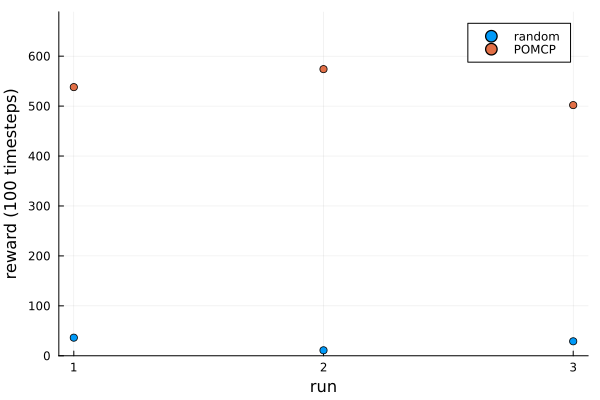

In [31]:
fig = plot(1:iters, [random_R,POMCPOW_R], 
    seriestype = :scatter, 
    label=["random" "POMCP"], 
    xticks = 0:1:iters,
    xlabel = "run",
    ylabel = "reward (" * string(steps) * " timesteps)",
    ylims = (0,maximum(POMCPOW_R)*1.2)
)
# savefig(fig,"./plots/reward_ID"*string(expID)*"_step"*string(steps)*"_roll"*string(iters)*".png")